# Predicting Stock Prices with Time Series Forecasting

This project focuses on forecasting stock prices for Apple Inc. (AAPL) using historical data from 2020 to 2025. We leverage time series forecasting techniques including ARIMA, LSTM, and Facebook Prophet to predict future stock trends. The models are evaluated using RMSE, MAE, and R-squared metrics to compare accuracy and performance. Data is sourced using the yfinance library and preprocessed with pandas.

## Setup & Data Loading

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
ticker = 'AAPL'
df = yf.download(ticker, start='2020-01-01', end='2025-01-01')

# Flatten MultiIndex columns after yfinance download
df.columns = df.columns.to_flat_index()

# Optional: Rename columns if needed
df.columns = [col if isinstance(col, str) else col[0] for col in df.columns]
df = df.reset_index()
df.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [4]:
# View first and last few records
print("Dataset Overview:")
print(df.head())
print("-"*80)
print(df.tail())

Dataset Overview:
          ds          y       High        Low       Open     Volume
0 2020-01-02  72.620857  72.681304  71.373233  71.627107  135480400
1 2020-01-03  71.914803  72.676431  71.689942  71.847102  146322800
2 2020-01-06  72.487862  72.526549  70.783263  71.034724  118387200
3 2020-01-07  72.146942  72.753823  71.926915  72.497529  108872000
4 2020-01-08  73.307518  73.609752  71.849540  71.849540  132079200
--------------------------------------------------------------------------------
             ds           y        High         Low        Open    Volume
1253 2024-12-24  257.578674  257.588630  254.675658  254.875189  23234700
1254 2024-12-26  258.396667  259.474086  257.010028  257.568678  27237100
1255 2024-12-27  254.974930  258.077462  252.451019  257.209530  42355300
1256 2024-12-30  251.593079  252.889953  250.146571  251.623005  35557500
1257 2024-12-31  249.817368  252.670486  248.829744  251.832511  39480700


## Exploratory Data Analysis & Visualization

In [5]:
# View structure and stats
print(df.info())
print("-"*80)
print(df.describe())
print("-"*80)
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1258 non-null   datetime64[ns]
 1   y       1258 non-null   float64       
 2   High    1258 non-null   float64       
 3   Low     1258 non-null   float64       
 4   Open    1258 non-null   float64       
 5   Volume  1258 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 59.1 KB
None
--------------------------------------------------------------------------------
                                  ds            y         High          Low  \
count                           1258  1258.000000  1258.000000  1258.000000   
mean   2022-07-01 15:39:46.645468928   151.978334   153.506152   150.274688   
min              2020-01-02 00:00:00    54.378590    55.379543    51.528423   
25%              2021-04-02 00:00:00   126.780115   127.902502   124.7

Index(['ds', 'y', 'High', 'Low', 'Open', 'Volume'], dtype='object')

In [6]:
# Check for missing values
print(df.isnull().sum())
print("-"*80)
print(df.shape)

ds        0
y         0
High      0
Low       0
Open      0
Volume    0
dtype: int64
--------------------------------------------------------------------------------
(1258, 6)


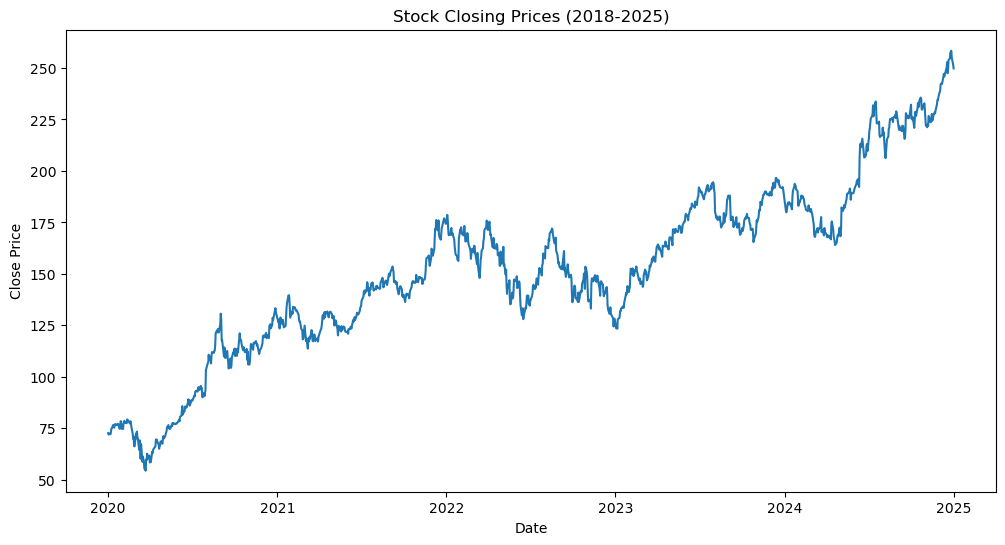

In [7]:
plt.figure(figsize=(12,6))
plt.plot(df['ds'], df['y'])
plt.title('Stock Closing Prices (2018-2025)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

## Data Preprocessing

In [8]:
# Normalize 'Close' for LSTM
scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(df['y'].values.reshape(-1, 1))

# Split data
train_size = int(len(df)*0.8)
train_df = df[:train_size]
test_df = df[train_size:]

## Implement ARIMA Model

In [9]:
from statsmodels.tsa.arima.model import ARIMA

# Train ARIMA model
model_arima = ARIMA(train_df['y'], order=(1,1,1))
result_arima = model_arima.fit()
forecast_arima = result_arima.forecast(steps=len(test_df))

# Evaluation
def evaluate(y_true, y_pred):
    return {
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred)
    }
    
arima_metrics = evaluate(test_df['y'], forecast_arima)
print("ARIMA Metrics:", arima_metrics)

ARIMA Metrics: {'RMSE': 29.71239878196658, 'MAE': 25.221328704086794, 'R2': -0.34681518577621273}


In [10]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_sarimax = SARIMAX(train_df['y'], order=(0,1,1), trend='c')
result_sarimax = model_sarimax.fit()
forecast_sarimax = result_sarimax.forecast(steps=len(test_df))

sarimax_metrics = evaluate(test_df['y'], forecast_sarimax)
print("SARIMAX Metrics:", sarimax_metrics)

SARIMAX Metrics: {'RMSE': 18.35571225653605, 'MAE': 15.96048306204704, 'R2': 0.4859858717941141}


## Implement LSTM Model

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

data = df[['y']].values

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

# Split into train/test
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape y_train for Dense layer compatibility
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Define LSTM model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    
    LSTM(units=50, return_sequences=True),
    Dropout(0.3),

    LSTM(units=50),
    Dropout(0.3),

    Dense(1)  # Single output node
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Predict
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

# Evaluate
def evaluate(y_true, y_pred):
    return {
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred)
    }

metrics = evaluate(y_true, y_pred)
print("Keras LSTM Metrics:", metrics)

Epoch 1/50
30/30 [==============================] - 27s 313ms/step - loss: 0.0284 - val_loss: 0.0186
Epoch 2/50
30/30 [==============================] - 6s 189ms/step - loss: 0.0056 - val_loss: 0.0055
Epoch 3/50
30/30 [==============================] - 6s 184ms/step - loss: 0.0049 - val_loss: 0.0019
Epoch 4/50
30/30 [==============================] - 6s 189ms/step - loss: 0.0044 - val_loss: 0.0048
Epoch 5/50
30/30 [==============================] - 6s 198ms/step - loss: 0.0043 - val_loss: 0.0070
Epoch 6/50
30/30 [==============================] - 6s 195ms/step - loss: 0.0037 - val_loss: 0.0049
Epoch 7/50
30/30 [==============================] - 6s 189ms/step - loss: 0.0038 - val_loss: 0.0031
Epoch 8/50
30/30 [==============================] - 5s 183ms/step - loss: 0.0039 - val_loss: 0.0032
Epoch 9/50
30/30 [==============================] - 6s 186ms/step - loss: 0.0036 - val_loss: 0.0029
Epoch 10/50
30/30 [==============================] - 5s 158ms/step - loss: 0.0034 - val_loss: 0.006

## Implement Prophet Model

In [12]:
from prophet import Prophet

# Rename columns for Prophet
prophet_df = df.rename(columns={'Date': 'ds', 'Close': 'y'})

# Ensure 'y' is numeric and 'ds' is datetime
prophet_df['y'] = pd.to_numeric(prophet_df['y'], errors='coerce')
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])

# Drop any rows with missing or infinite values
prophet_df = prophet_df.dropna(subset=['ds', 'y'])
prophet_df = prophet_df[np.isfinite(prophet_df['y'])]

# Split the data
train_prophet = prophet_df.iloc[:train_size]
test_prophet = prophet_df.iloc[train_size:]

# Fit the model
model_prophet = Prophet(daily_seasonality=True)
model_prophet.fit(train_prophet)

# Forecast
future = model_prophet.make_future_dataframe(periods=len(test_prophet))
forecast = model_prophet.predict(future)

# Predictions
prophet_preds = forecast.iloc[-len(test_prophet):]['yhat'].values
prophet_metrics = evaluate(test_prophet['y'], prophet_preds)
print("Prophet Metrics:", prophet_metrics)

20:01:40 - cmdstanpy - INFO - Chain [1] start processing
20:01:40 - cmdstanpy - INFO - Chain [1] done processing


Prophet Metrics: {'RMSE': 18.554270155034516, 'MAE': 13.221642508137414, 'R2': 0.4445368928901796}


In [13]:
# Make predictions using the trained Keras LSTM model
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

# Evaluate LSTM model
lstm_metrics = evaluate(y_true, y_pred)

# Print all metrics
print("\nFinal Model Comparison:")
print("-"*90)
print("ARIMA:", arima_metrics)
print("-"*90)
print("SARIMAX:", sarimax_metrics)
print("-"*90)
print("LSTM:", lstm_metrics)
print("-"*90)
print("Prophet:", prophet_metrics)

8/8 [==============================] - 0s 11ms/step

Final Model Comparison:
------------------------------------------------------------------------------------------
ARIMA: {'RMSE': 29.71239878196658, 'MAE': 25.221328704086794, 'R2': -0.34681518577621273}
------------------------------------------------------------------------------------------
SARIMAX: {'RMSE': 18.35571225653605, 'MAE': 15.96048306204704, 'R2': 0.4859858717941141}
------------------------------------------------------------------------------------------
LSTM: {'RMSE': 9.050385903938036, 'MAE': 7.352552350362142, 'R2': 0.8759864266832529}
------------------------------------------------------------------------------------------
Prophet: {'RMSE': 18.554270155034516, 'MAE': 13.221642508137414, 'R2': 0.4445368928901796}


In [14]:
print(f"test_df['ds'] length: {len(test_df['ds'])}")
print(f"prophet_preds length: {len(prophet_preds)}")

test_df['ds'] length: 252
prophet_preds length: 300


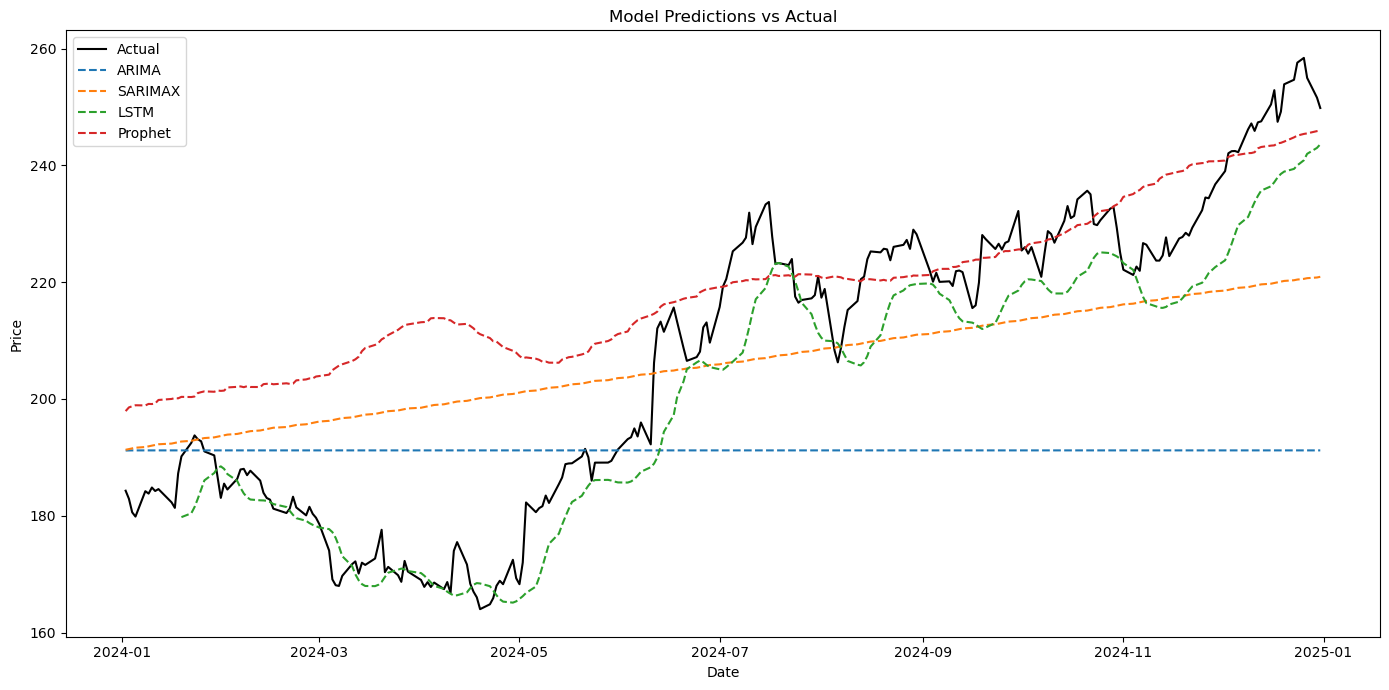

In [15]:
# Plot all model predictions
plt.figure(figsize=(14, 7))
plt.plot(test_df['ds'], test_df['y'], label='Actual', color='black')
plt.plot(test_df['ds'], forecast_arima, label='ARIMA', linestyle='dashed')
plt.plot(test_df['ds'], forecast_sarimax, label='SARIMAX', linestyle='dashed')
plt.plot(test_df['ds'][-len(y_pred):], y_pred, label='LSTM', linestyle='dashed')
plt.plot(test_df['ds'], prophet_preds[-len(test_df):], label='Prophet', linestyle='dashed')
plt.title("Model Predictions vs Actual")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()

## Conclusion

In this stock price forecasting project, we evaluated four time series models—ARIMA, SARIMAX, LSTM, and Prophet—on Apple Inc. (AAPL) historical data from 2020 to 2025. The performance of each model was assessed using RMSE, MAE, and R² score.

### Final Model Performance:

* ARIMA: Poor performance with high error and negative R² (RMSE: 29.71, R²: -0.35), indicating an inability to capture the data trend.
* SARIMAX: Moderate performance (RMSE: 18.36, R²: 0.49), better than ARIMA due to seasonality handling.
* Prophet: Slightly worse than SARIMAX (RMSE: 18.55, R²: 0.44), though still acceptable for capturing general trends.
* LSTM: Best performance with the lowest error (RMSE: 9.05, MAE: 7.35) and highest R² score of 0.88, showing strong capability in modeling nonlinear patterns and temporal dependencies.

### Key Insight:

The LSTM model significantly outperformed traditional statistical models, making it the most suitable choice for stock price prediction in this case. While SARIMAX and Prophet can offer reasonable trend estimates, deep learning models like LSTM deliver far superior accuracy when sufficient data and computational resources are available.

 -By Akshara S, Data Science Intern at inGrade